<a href="https://colab.research.google.com/github/rupeshpoojary97/Deep-Learning-Projects/blob/main/Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import the libraries and Input to the model

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19
from keras.preprocessing.image import load_img

base_image_path = 'sailboat.jpg'
style_reference_image_path = 'soap_bubble.jpg'

    
result_prefix = "image_generated"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

# Dimensions of the generated picture.
width, height = keras.preprocessing.image.load_img(base_image_path).size
img_nrows = 400
img_ncols = int(width * img_nrows / height)

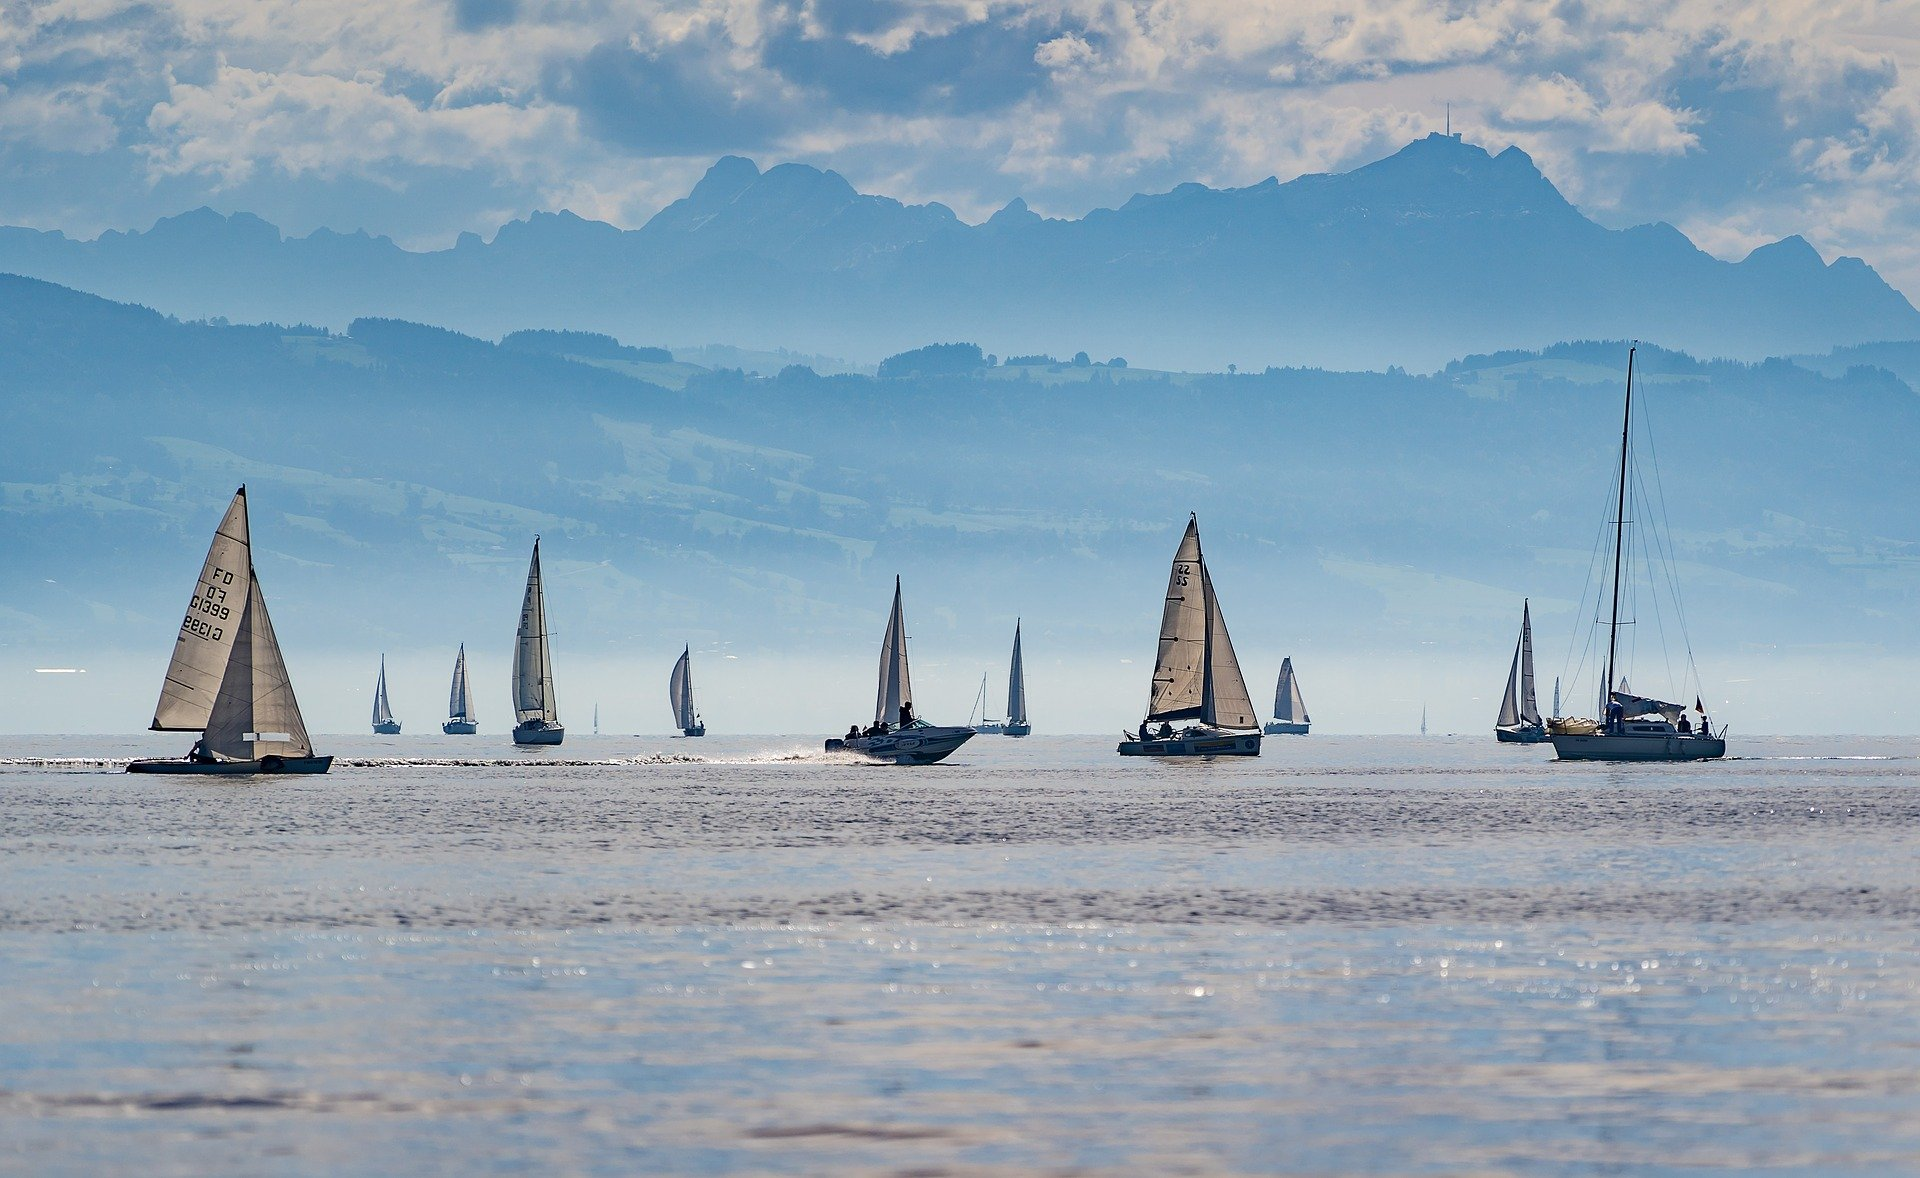

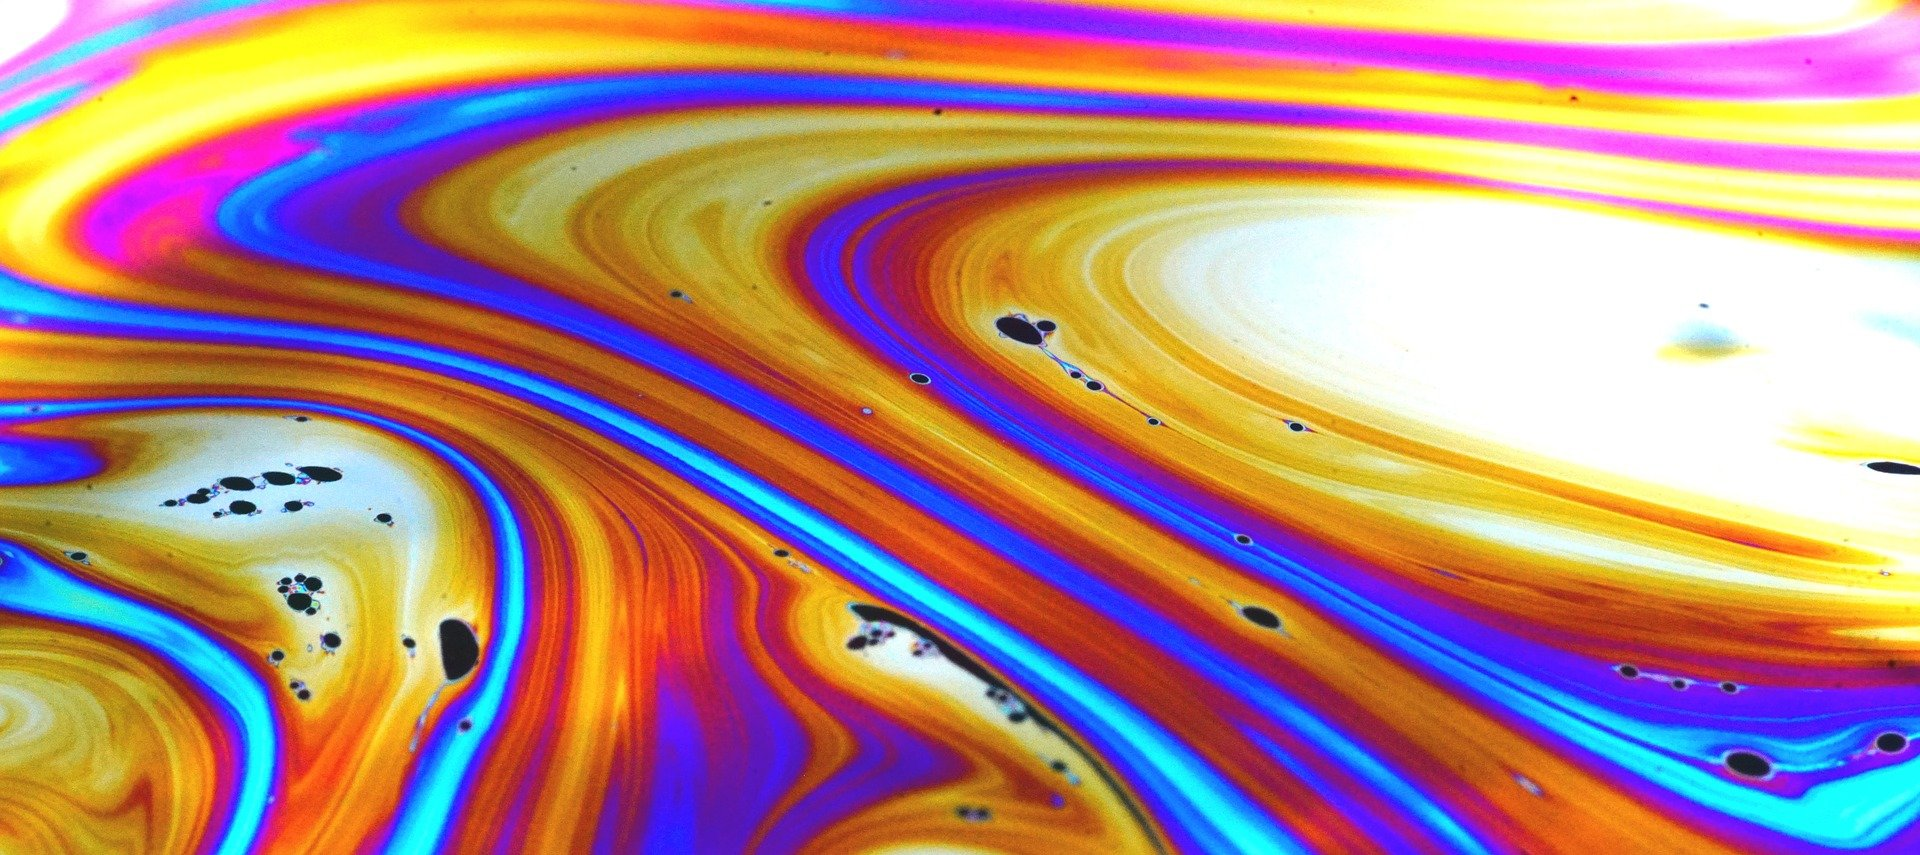

In [14]:
from IPython.display import Image, display

display(Image(base_image_path))
display(Image(style_reference_image_path))

Preprocess the image. It will be used to preprocess the style and the content image, that we will give to the network.

In [15]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures into appropriate tensors
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_nrows, img_ncols)
    )
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)




Once the candidate image is generated, we will plot it to see the result after deprocessing it using the following function.

In [16]:
def deprocess_image(x):
    # Util function to convert a tensor into a valid image
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

## Loss Function
Now we will define the loss functions for the style loss and the content loss. For the style loss, we will define the Gram matrix.

### Define Gram matrix
How do you capture relationship between 2 vector? By correlation! Correlation is a statistical measure that captures the relationship between 2 varibles. Correlation indicates the extent to which change in one variable increase or decrease the other variable.


We may see an image as distribution over different feature vectors. Each feature vector in a layer captures some aspect of image. For example, in the initial layer, feature vectors captures edges. Gram matrix captures correlation between different feature vectors, not the presence or absence of specific features. Gram matrix is the product between a matrix and its transpose.

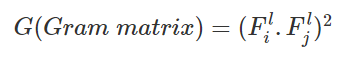

In [17]:
# The gram matrix of an image tensor (feature-wise outer product)


def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram




### Define Style Loss
The style loss is sum of L2 distances between the Gram matrices of the representations of the generated image and the style image, extracted from different layers of CNN(here, VGGNet). The general idea is to capture style (color/texture/shapes/edges etc) at different layers.

Let $A^l$ and $G^l$ style representations of generated(artistic) and style image in layer $l$. The contribution of that layer to the total loss is:
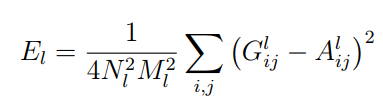
and the total style loss is: 
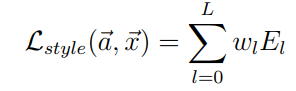

In [18]:
# The "style loss" is designed to maintain
# the style of the reference image in the generated image.
# It is based on the gram matrices (which capture style) of
# feature maps from the style reference image
# and from the generated image


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))




### Define Content Loss
The content loss is a L2 distance between the features of the generated image and the features of the content image. Let $P^l$ and $F^l$ be feature representation of content image and generated image in layer $l$. We then define the squared-error loss between the two feature representations as:
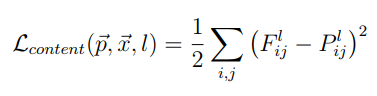

In [19]:
# An auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))






## Total variation loss

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the *total variation loss*:

In [20]:
# The 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    a = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, 1:, : img_ncols - 1, :]
    )
    b = tf.square(
        x[:, : img_nrows - 1, : img_ncols - 1, :] - x[:, : img_nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

### Load VGG19 model 

In [21]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
model = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

print(model.summary())

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

Finally, here's the code that computes the style transfer loss.

In [22]:
# List of layers to use for the style loss.
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss.
content_layer_name = "block5_conv2"


def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


## Add a tf.function decorator to loss & gradient computation

To compile it, and thus make it fast.

In [23]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

## The training loop
Repeatedly run vanilla gradient descent steps to minimize the loss, and save the resulting image every 100 iterations.

We decay the learning rate by 0.96 every 100 steps.

In [24]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 100
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    print("Iteration %d: loss=%.2f" % (i, loss))
    img = deprocess_image(combination_image.numpy())
    fname = result_prefix + "_at_iteration_%d.png" % i
    keras.preprocessing.image.save_img(fname, img)

Iteration 1: loss=447973.62
Iteration 2: loss=421261.50
Iteration 3: loss=363468.75
Iteration 4: loss=295449.72
Iteration 5: loss=225840.34
Iteration 6: loss=167921.75
Iteration 7: loss=134898.06
Iteration 8: loss=117834.01
Iteration 9: loss=106742.46
Iteration 10: loss=98293.80
Iteration 11: loss=92063.95
Iteration 12: loss=86594.05
Iteration 13: loss=82634.05
Iteration 14: loss=77685.93
Iteration 15: loss=73545.54
Iteration 16: loss=69217.07
Iteration 17: loss=65906.70
Iteration 18: loss=62957.19
Iteration 19: loss=60584.45
Iteration 20: loss=58437.50
Iteration 21: loss=56305.64
Iteration 22: loss=54652.83
Iteration 23: loss=52286.83
Iteration 24: loss=50538.52
Iteration 25: loss=48232.06
Iteration 26: loss=46494.20
Iteration 27: loss=44524.44
Iteration 28: loss=43001.36
Iteration 29: loss=41554.46
Iteration 30: loss=40438.36
Iteration 31: loss=39958.55
Iteration 32: loss=40235.09
Iteration 33: loss=42419.62
Iteration 34: loss=41044.67
Iteration 35: loss=41755.40
Iteration 36: loss=3

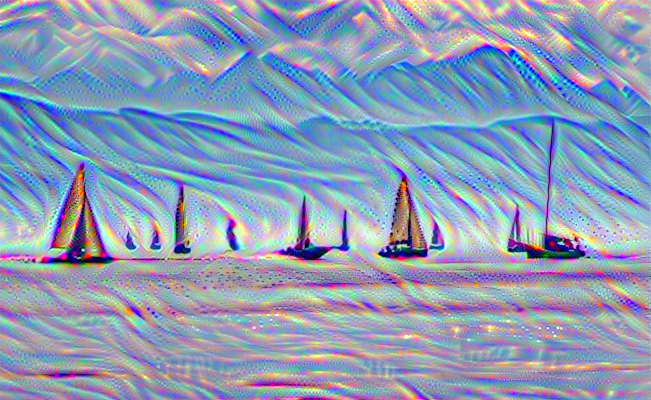

In [25]:
display(Image(result_prefix + "_at_iteration_100.png"))